# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 13:21 - loss: 0.6935

  27/1875 [..............................] - ETA: 3s - loss: 0.5474   

  55/1875 [..............................] - ETA: 3s - loss: 0.4662

  82/1875 [>.............................] - ETA: 3s - loss: 0.4253

 111/1875 [>.............................] - ETA: 3s - loss: 0.3971

 141/1875 [=>............................] - ETA: 3s - loss: 0.3765

 175/1875 [=>............................] - ETA: 2s - loss: 0.3589

 209/1875 [==>...........................] - ETA: 2s - loss: 0.3450

 238/1875 [==>...........................] - ETA: 2s - loss: 0.3350

 267/1875 [===>..........................] - ETA: 2s - loss: 0.3264

 296/1875 [===>..........................] - ETA: 2s - loss: 0.3188

 326/1875 [====>.........................] - ETA: 2s - loss: 0.3118

 357/1875 [====>.........................] - ETA: 2s - loss: 0.3053

 386/1875 [=====>........................] - ETA: 2s - loss: 0.2997

 417/1875 [=====>........................] - ETA: 2s - loss: 0.2943

 448/1875 [======>.......................] - ETA: 2s - loss: 0.2894

 476/1875 [======>.......................] - ETA: 2s - loss: 0.2852

 512/1875 [=======>......................] - ETA: 2s - loss: 0.2803

 548/1875 [=======>......................] - ETA: 2s - loss: 0.2757

 578/1875 [========>.....................] - ETA: 2s - loss: 0.2722

 615/1875 [========>.....................] - ETA: 2s - loss: 0.2681

 648/1875 [=========>....................] - ETA: 2s - loss: 0.2647

 677/1875 [=========>....................] - ETA: 1s - loss: 0.2619

 706/1875 [==========>...................] - ETA: 1s - loss: 0.2592

 733/1875 [==========>...................] - ETA: 1s - loss: 0.2568

 762/1875 [===========>..................] - ETA: 1s - loss: 0.2543

 792/1875 [===========>..................] - ETA: 1s - loss: 0.2519

 823/1875 [============>.................] - ETA: 1s - loss: 0.2495

 853/1875 [============>.................] - ETA: 1s - loss: 0.2473

 888/1875 [=============>................] - ETA: 1s - loss: 0.2448

 912/1875 [=============>................] - ETA: 1s - loss: 0.2432

 942/1875 [==============>...............] - ETA: 1s - loss: 0.2412

 967/1875 [==============>...............] - ETA: 1s - loss: 0.2396

 997/1875 [==============>...............] - ETA: 1s - loss: 0.2377

1030/1875 [===============>..............] - ETA: 1s - loss: 0.2358

1061/1875 [===============>..............] - ETA: 1s - loss: 0.2340

1096/1875 [================>.............] - ETA: 1s - loss: 0.2321

1132/1875 [=================>............] - ETA: 1s - loss: 0.2302

1166/1875 [=================>............] - ETA: 1s - loss: 0.2284

1199/1875 [==================>...........] - ETA: 1s - loss: 0.2268

1235/1875 [==================>...........] - ETA: 1s - loss: 0.2251

1265/1875 [===================>..........] - ETA: 1s - loss: 0.2237

1294/1875 [===================>..........] - ETA: 0s - loss: 0.2224

1330/1875 [====================>.........] - ETA: 0s - loss: 0.2208

1365/1875 [====================>.........] - ETA: 0s - loss: 0.2194

1399/1875 [=====================>........] - ETA: 0s - loss: 0.2180

1431/1875 [=====================>........] - ETA: 0s - loss: 0.2167

1466/1875 [======================>.......] - ETA: 0s - loss: 0.2154

1496/1875 [======================>.......] - ETA: 0s - loss: 0.2142

1528/1875 [=======================>......] - ETA: 0s - loss: 0.2131

1558/1875 [=======================>......] - ETA: 0s - loss: 0.2120

1596/1875 [========================>.....] - ETA: 0s - loss: 0.2107

1624/1875 [========================>.....] - ETA: 0s - loss: 0.2097

1655/1875 [=========================>....] - ETA: 0s - loss: 0.2087

1687/1875 [=========================>....] - ETA: 0s - loss: 0.2077

1715/1875 [==========================>...] - ETA: 0s - loss: 0.2068

1743/1875 [==========================>...] - ETA: 0s - loss: 0.2059

1770/1875 [===========================>..] - ETA: 0s - loss: 0.2051

1798/1875 [===========================>..] - ETA: 0s - loss: 0.2043

1829/1875 [============================>.] - ETA: 0s - loss: 0.2034

1861/1875 [============================>.] - ETA: 0s - loss: 0.2024

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2020


Epoch 2/5
   1/1875 [..............................] - ETA: 2s - loss: 0.1030

  26/1875 [..............................] - ETA: 3s - loss: 0.1088

  52/1875 [..............................] - ETA: 3s - loss: 0.1089

  76/1875 [>.............................] - ETA: 3s - loss: 0.1090

  99/1875 [>.............................] - ETA: 3s - loss: 0.1091

 128/1875 [=>............................] - ETA: 3s - loss: 0.1091

 162/1875 [=>............................] - ETA: 3s - loss: 0.1090

 196/1875 [==>...........................] - ETA: 3s - loss: 0.1089

 232/1875 [==>...........................] - ETA: 2s - loss: 0.1088

 267/1875 [===>..........................] - ETA: 2s - loss: 0.1088

 297/1875 [===>..........................] - ETA: 2s - loss: 0.1087

 333/1875 [====>.........................] - ETA: 2s - loss: 0.1087

 362/1875 [====>.........................] - ETA: 2s - loss: 0.1086

 392/1875 [=====>........................] - ETA: 2s - loss: 0.1086

 421/1875 [=====>........................] - ETA: 2s - loss: 0.1085

 455/1875 [======>.......................] - ETA: 2s - loss: 0.1085

 492/1875 [======>.......................] - ETA: 2s - loss: 0.1084

 526/1875 [=======>......................] - ETA: 2s - loss: 0.1083

 564/1875 [========>.....................] - ETA: 2s - loss: 0.1083

 600/1875 [========>.....................] - ETA: 2s - loss: 0.1082

 636/1875 [=========>....................] - ETA: 1s - loss: 0.1081

 669/1875 [=========>....................] - ETA: 1s - loss: 0.1080

 698/1875 [==========>...................] - ETA: 1s - loss: 0.1080

 734/1875 [==========>...................] - ETA: 1s - loss: 0.1079

 759/1875 [===========>..................] - ETA: 1s - loss: 0.1079

 790/1875 [===========>..................] - ETA: 1s - loss: 0.1078

 818/1875 [============>.................] - ETA: 1s - loss: 0.1077

 846/1875 [============>.................] - ETA: 1s - loss: 0.1077

 875/1875 [=============>................] - ETA: 1s - loss: 0.1076

 903/1875 [=============>................] - ETA: 1s - loss: 0.1076

 930/1875 [=============>................] - ETA: 1s - loss: 0.1075

 956/1875 [==============>...............] - ETA: 1s - loss: 0.1075

 983/1875 [==============>...............] - ETA: 1s - loss: 0.1074

1012/1875 [===============>..............] - ETA: 1s - loss: 0.1074

1039/1875 [===============>..............] - ETA: 1s - loss: 0.1073

1065/1875 [================>.............] - ETA: 1s - loss: 0.1073

1093/1875 [================>.............] - ETA: 1s - loss: 0.1072

1123/1875 [================>.............] - ETA: 1s - loss: 0.1071

1151/1875 [=================>............] - ETA: 1s - loss: 0.1071

1180/1875 [=================>............] - ETA: 1s - loss: 0.1070

1207/1875 [==================>...........] - ETA: 1s - loss: 0.1070

1240/1875 [==================>...........] - ETA: 1s - loss: 0.1069

1275/1875 [===================>..........] - ETA: 1s - loss: 0.1069

1311/1875 [===================>..........] - ETA: 0s - loss: 0.1068

1347/1875 [====================>.........] - ETA: 0s - loss: 0.1067

1383/1875 [=====================>........] - ETA: 0s - loss: 0.1067

1413/1875 [=====================>........] - ETA: 0s - loss: 0.1066

1441/1875 [======================>.......] - ETA: 0s - loss: 0.1066

1477/1875 [======================>.......] - ETA: 0s - loss: 0.1065

1513/1875 [=======================>......] - ETA: 0s - loss: 0.1065

1549/1875 [=======================>......] - ETA: 0s - loss: 0.1064

1578/1875 [========================>.....] - ETA: 0s - loss: 0.1063

1612/1875 [========================>.....] - ETA: 0s - loss: 0.1063

1644/1875 [=========================>....] - ETA: 0s - loss: 0.1062

1680/1875 [=========================>....] - ETA: 0s - loss: 0.1062

1716/1875 [==========================>...] - ETA: 0s - loss: 0.1061

1751/1875 [===========================>..] - ETA: 0s - loss: 0.1061

1780/1875 [===========================>..] - ETA: 0s - loss: 0.1060

1810/1875 [===========================>..] - ETA: 0s - loss: 0.1060

1839/1875 [============================>.] - ETA: 0s - loss: 0.1059

1873/1875 [============================>.] - ETA: 0s - loss: 0.1059

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1059


Epoch 3/5
   1/1875 [..............................] - ETA: 9s - loss: 0.0918

  35/1875 [..............................] - ETA: 2s - loss: 0.0970

  66/1875 [>.............................] - ETA: 2s - loss: 0.0980

  95/1875 [>.............................] - ETA: 2s - loss: 0.0982

 124/1875 [>.............................] - ETA: 2s - loss: 0.0983

 154/1875 [=>............................] - ETA: 2s - loss: 0.0983

 188/1875 [==>...........................] - ETA: 2s - loss: 0.0984

 218/1875 [==>...........................] - ETA: 2s - loss: 0.0984

 245/1875 [==>...........................] - ETA: 2s - loss: 0.0983

 274/1875 [===>..........................] - ETA: 2s - loss: 0.0983

 303/1875 [===>..........................] - ETA: 2s - loss: 0.0983

 331/1875 [====>.........................] - ETA: 2s - loss: 0.0983

 361/1875 [====>.........................] - ETA: 2s - loss: 0.0983

 395/1875 [=====>........................] - ETA: 2s - loss: 0.0983

 421/1875 [=====>........................] - ETA: 2s - loss: 0.0983

 454/1875 [======>.......................] - ETA: 2s - loss: 0.0983

 483/1875 [======>.......................] - ETA: 2s - loss: 0.0982

 512/1875 [=======>......................] - ETA: 2s - loss: 0.0982

 548/1875 [=======>......................] - ETA: 2s - loss: 0.0982

 584/1875 [========>.....................] - ETA: 2s - loss: 0.0982

 618/1875 [========>.....................] - ETA: 2s - loss: 0.0982

 653/1875 [=========>....................] - ETA: 1s - loss: 0.0982

 689/1875 [==========>...................] - ETA: 1s - loss: 0.0982

 719/1875 [==========>...................] - ETA: 1s - loss: 0.0981

 752/1875 [===========>..................] - ETA: 1s - loss: 0.0981

 787/1875 [===========>..................] - ETA: 1s - loss: 0.0981

 819/1875 [============>.................] - ETA: 1s - loss: 0.0981

 850/1875 [============>.................] - ETA: 1s - loss: 0.0981

 880/1875 [=============>................] - ETA: 1s - loss: 0.0981

 910/1875 [=============>................] - ETA: 1s - loss: 0.0981

 946/1875 [==============>...............] - ETA: 1s - loss: 0.0981

 979/1875 [==============>...............] - ETA: 1s - loss: 0.0981

1011/1875 [===============>..............] - ETA: 1s - loss: 0.0981

1046/1875 [===============>..............] - ETA: 1s - loss: 0.0981

1080/1875 [================>.............] - ETA: 1s - loss: 0.0980

1114/1875 [================>.............] - ETA: 1s - loss: 0.0980

1149/1875 [=================>............] - ETA: 1s - loss: 0.0980

1186/1875 [=================>............] - ETA: 1s - loss: 0.0980

1222/1875 [==================>...........] - ETA: 1s - loss: 0.0980

1253/1875 [===================>..........] - ETA: 0s - loss: 0.0980

1288/1875 [===================>..........] - ETA: 0s - loss: 0.0980

1321/1875 [====================>.........] - ETA: 0s - loss: 0.0980

1351/1875 [====================>.........] - ETA: 0s - loss: 0.0980

1386/1875 [=====================>........] - ETA: 0s - loss: 0.0980

1420/1875 [=====================>........] - ETA: 0s - loss: 0.0980

1453/1875 [======================>.......] - ETA: 0s - loss: 0.0980

1487/1875 [======================>.......] - ETA: 0s - loss: 0.0979

1523/1875 [=======================>......] - ETA: 0s - loss: 0.0979

1556/1875 [=======================>......] - ETA: 0s - loss: 0.0979

1591/1875 [========================>.....] - ETA: 0s - loss: 0.0979

1627/1875 [=========================>....] - ETA: 0s - loss: 0.0979

1663/1875 [=========================>....] - ETA: 0s - loss: 0.0979

1697/1875 [==========================>...] - ETA: 0s - loss: 0.0979

1729/1875 [==========================>...] - ETA: 0s - loss: 0.0979

1758/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1786/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1815/1875 [============================>.] - ETA: 0s - loss: 0.0979

1845/1875 [============================>.] - ETA: 0s - loss: 0.0979

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0979


Epoch 4/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0951

  35/1875 [..............................] - ETA: 2s - loss: 0.0986

  69/1875 [>.............................] - ETA: 2s - loss: 0.0980

  97/1875 [>.............................] - ETA: 2s - loss: 0.0977

 126/1875 [=>............................] - ETA: 2s - loss: 0.0974

 156/1875 [=>............................] - ETA: 2s - loss: 0.0972

 186/1875 [=>............................] - ETA: 2s - loss: 0.0970

 221/1875 [==>...........................] - ETA: 2s - loss: 0.0969

 252/1875 [===>..........................] - ETA: 2s - loss: 0.0968

 283/1875 [===>..........................] - ETA: 2s - loss: 0.0967

 316/1875 [====>.........................] - ETA: 2s - loss: 0.0967

 352/1875 [====>.........................] - ETA: 2s - loss: 0.0966

 380/1875 [=====>........................] - ETA: 2s - loss: 0.0966

 415/1875 [=====>........................] - ETA: 2s - loss: 0.0966

 445/1875 [======>.......................] - ETA: 2s - loss: 0.0966

 472/1875 [======>.......................] - ETA: 2s - loss: 0.0965

 502/1875 [=======>......................] - ETA: 2s - loss: 0.0965

 533/1875 [=======>......................] - ETA: 2s - loss: 0.0965

 562/1875 [=======>......................] - ETA: 2s - loss: 0.0965

 594/1875 [========>.....................] - ETA: 2s - loss: 0.0965

 626/1875 [=========>....................] - ETA: 2s - loss: 0.0965

 654/1875 [=========>....................] - ETA: 2s - loss: 0.0965

 685/1875 [=========>....................] - ETA: 1s - loss: 0.0964

 716/1875 [==========>...................] - ETA: 1s - loss: 0.0964

 752/1875 [===========>..................] - ETA: 1s - loss: 0.0964

 788/1875 [===========>..................] - ETA: 1s - loss: 0.0964

 822/1875 [============>.................] - ETA: 1s - loss: 0.0964

 855/1875 [============>.................] - ETA: 1s - loss: 0.0964

 889/1875 [=============>................] - ETA: 1s - loss: 0.0964

 920/1875 [=============>................] - ETA: 1s - loss: 0.0964

 949/1875 [==============>...............] - ETA: 1s - loss: 0.0964

 978/1875 [==============>...............] - ETA: 1s - loss: 0.0964

1013/1875 [===============>..............] - ETA: 1s - loss: 0.0964

1047/1875 [===============>..............] - ETA: 1s - loss: 0.0964

1075/1875 [================>.............] - ETA: 1s - loss: 0.0964

1107/1875 [================>.............] - ETA: 1s - loss: 0.0964

1143/1875 [=================>............] - ETA: 1s - loss: 0.0964

1174/1875 [=================>............] - ETA: 1s - loss: 0.0964

1204/1875 [==================>...........] - ETA: 1s - loss: 0.0964

1233/1875 [==================>...........] - ETA: 1s - loss: 0.0964

1265/1875 [===================>..........] - ETA: 0s - loss: 0.0964

1294/1875 [===================>..........] - ETA: 0s - loss: 0.0964

1323/1875 [====================>.........] - ETA: 0s - loss: 0.0964

1348/1875 [====================>.........] - ETA: 0s - loss: 0.0964

1381/1875 [=====================>........] - ETA: 0s - loss: 0.0964

1417/1875 [=====================>........] - ETA: 0s - loss: 0.0964

1450/1875 [======================>.......] - ETA: 0s - loss: 0.0964

1486/1875 [======================>.......] - ETA: 0s - loss: 0.0964

1516/1875 [=======================>......] - ETA: 0s - loss: 0.0964

1543/1875 [=======================>......] - ETA: 0s - loss: 0.0964

1575/1875 [========================>.....] - ETA: 0s - loss: 0.0964

1611/1875 [========================>.....] - ETA: 0s - loss: 0.0964

1647/1875 [=========================>....] - ETA: 0s - loss: 0.0964

1679/1875 [=========================>....] - ETA: 0s - loss: 0.0964

1707/1875 [==========================>...] - ETA: 0s - loss: 0.0963

1740/1875 [==========================>...] - ETA: 0s - loss: 0.0963

1774/1875 [===========================>..] - ETA: 0s - loss: 0.0963

1796/1875 [===========================>..] - ETA: 0s - loss: 0.0963

1830/1875 [============================>.] - ETA: 0s - loss: 0.0963

1856/1875 [============================>.] - ETA: 0s - loss: 0.0963

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0963


Epoch 5/5
   1/1875 [..............................] - ETA: 6s - loss: 0.0915

  27/1875 [..............................] - ETA: 3s - loss: 0.0958

  55/1875 [..............................] - ETA: 3s - loss: 0.0957

  77/1875 [>.............................] - ETA: 3s - loss: 0.0956

 103/1875 [>.............................] - ETA: 3s - loss: 0.0954

 131/1875 [=>............................] - ETA: 3s - loss: 0.0953

 161/1875 [=>............................] - ETA: 3s - loss: 0.0952

 191/1875 [==>...........................] - ETA: 3s - loss: 0.0951

 221/1875 [==>...........................] - ETA: 3s - loss: 0.0951

 252/1875 [===>..........................] - ETA: 2s - loss: 0.0951

 282/1875 [===>..........................] - ETA: 2s - loss: 0.0951

 311/1875 [===>..........................] - ETA: 2s - loss: 0.0951

 340/1875 [====>.........................] - ETA: 2s - loss: 0.0951

 367/1875 [====>.........................] - ETA: 2s - loss: 0.0952

 396/1875 [=====>........................] - ETA: 2s - loss: 0.0952

 422/1875 [=====>........................] - ETA: 2s - loss: 0.0952

 453/1875 [======>.......................] - ETA: 2s - loss: 0.0952

 482/1875 [======>.......................] - ETA: 2s - loss: 0.0953

 514/1875 [=======>......................] - ETA: 2s - loss: 0.0953

 547/1875 [=======>......................] - ETA: 2s - loss: 0.0953

 583/1875 [========>.....................] - ETA: 2s - loss: 0.0953

 619/1875 [========>.....................] - ETA: 2s - loss: 0.0953

 648/1875 [=========>....................] - ETA: 2s - loss: 0.0953

 676/1875 [=========>....................] - ETA: 2s - loss: 0.0953

 707/1875 [==========>...................] - ETA: 2s - loss: 0.0953

 743/1875 [==========>...................] - ETA: 1s - loss: 0.0954

 778/1875 [===========>..................] - ETA: 1s - loss: 0.0954

 814/1875 [============>.................] - ETA: 1s - loss: 0.0954

 849/1875 [============>.................] - ETA: 1s - loss: 0.0954

 883/1875 [=============>................] - ETA: 1s - loss: 0.0954

 919/1875 [=============>................] - ETA: 1s - loss: 0.0954

 955/1875 [==============>...............] - ETA: 1s - loss: 0.0954

 985/1875 [==============>...............] - ETA: 1s - loss: 0.0954

1018/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1052/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1088/1875 [================>.............] - ETA: 1s - loss: 0.0954

1124/1875 [================>.............] - ETA: 1s - loss: 0.0954

1160/1875 [=================>............] - ETA: 1s - loss: 0.0954

1195/1875 [==================>...........] - ETA: 1s - loss: 0.0954

1231/1875 [==================>...........] - ETA: 1s - loss: 0.0954

1262/1875 [===================>..........] - ETA: 0s - loss: 0.0954

1295/1875 [===================>..........] - ETA: 0s - loss: 0.0954

1328/1875 [====================>.........] - ETA: 0s - loss: 0.0954

1364/1875 [====================>.........] - ETA: 0s - loss: 0.0954

1395/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1425/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1452/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1481/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1509/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1539/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1564/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1591/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1625/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1655/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1686/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1722/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1756/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1784/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1812/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1842/1875 [============================>.] - ETA: 0s - loss: 0.0954

1872/1875 [============================>.] - ETA: 0s - loss: 0.0954

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0954


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

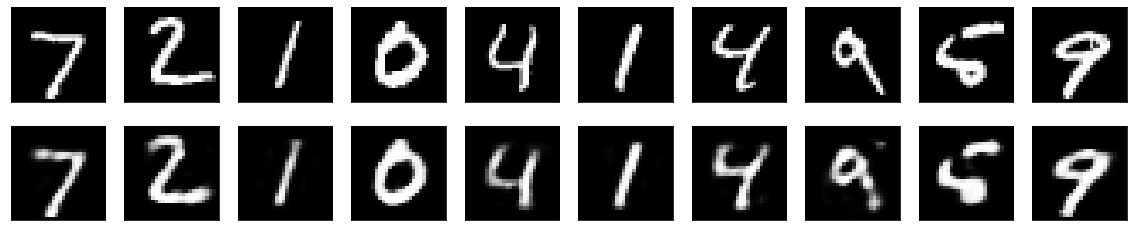

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
